1 start
1 end
[ 2.17461585e+00  8.76810420e-34  7.74598867e-34 -1.89687499e-34]


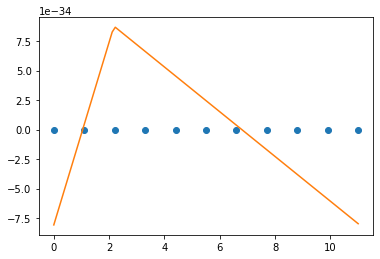

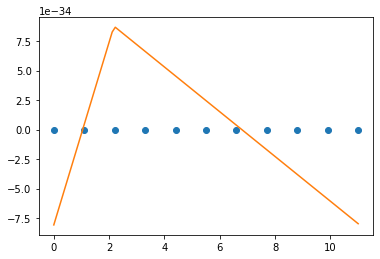

In [5]:
#simulate the model of Corey for epidemics with different latent times

    #a) agent-based model

        #agents are in five compartments: SEI(A)IR (2 I compartments: asymptomatic, symptomatic)
        #S are susceptible, E are infected but in the latency state, I are infected and infectious and R recovered.
        #S+E+R move freely on a spatial network (2d lattice)
        #I do not move
        
        #S+I->I+E with prob beta
        #E->I after a certain latent time T_l (deterministic or from a distribution)
        #I->R after a certain infectious time T_i (deterministic or from a distribution)
        
    #b) network minimal model for comparison of basic mechanism
        
        #metapopulation-like model
        #interaction network is a sum of powers of the mobility network in a) up to power T_l
        #Time is in generations, where a genera1tion is takes a time of T_l
        
import networkx as nx
import numpy as np
from numpy.random import binomial,seed
import random
import matplotlib.pyplot as plt
import os
from scipy.stats import erlang
import csv
import pandas as pd

random.seed(12345)
seed(seed=12345)
#a) ABM

#initialize

## space and demographics

l=15 # sides of the square lattice
n_agloc=300 # number of agents in each location initially

N_loc=l*l # number of locations
N_agents=n_agloc*N_loc# total number of agents
G=nx.grid_2d_graph(l,l) # network for the spatial substrate

## epidemic model parameters

m=1 # number of steps per day

alpha_init=0.05 #moving probability
beta_init=0.15 # force of infection
mu_recover=0.1 # recovery rate
delta=0.001 #flight prob; not currently used
perc_asymp=0.5 # % asymptomatic

t_ld_a=70 #time lockdown announced
t_ld_b=75 #time lockdown begins

beta_inc=beta_init*2 #beta increase after lockdown announced
beta_dec=beta_init*0.5 #beta decrease after lockdown begins

alpha_inc=alpha_init*2 #travel increase after lockdown announced
alpha_dec=alpha_init*0.1 #travel decrease after lockdown begins

exp=2 #exponent for the gravity law for mobility



T_l=5 # incubation period
#alpha_step=1-np.power((1-alpha),1.0/float(m)) # probability of moving
#beta_step=beta/(m) # probability of disease transmission
mu_step=1-np.power((1-mu_recover),1.0/float(m)) # probability of recovery
gamma=0 # increase/decrease on moving probability for infectious individuals

# other parameters

end_time=300

#choose how the incubation periods are chosen from an Erlang distribution
# parameters of the distribution: k=shape, mu=scale; 
                                #T_l=k*mu (mean), sigma^2=k*mu^2 (variance);
                                #k=(T_l/sigma)^2, mu=sigma^2/T_l
    #1- constant variance sigma_0^2 across different T_l's
    #2- constant k (not 1, because with k=1 we have an exponential distribution),
    #sigma increases with T_l 

erlang_type=2
sigma_0=2 # will use only in case erlang_type=1 (constant variance)
k=10 # will use only in case erlang_type=2 (constant k)
if erlang_type==1:
    a=T_l/sigma_0
    mu=sigma_0/a
    k=a*a
elif erlang_type==2:
    mu=T_l/k
    
rv=erlang(k,scale=mu)

## give locations to all agents

Nruns=1


peak_height=list()
peak_time=list()
start_time=list()
inf_per_day=list()
day_50=list()
day_100=list()
day_150=list()
day_200=list()


for irun in range(Nruns):
    print (Nruns-irun,'start')

    loc=dict() # location of each agent
    agents=dict() # agents in each location
    S=dict() # S agents in each location
    E=dict() # E agents in each location
    IAS=dict() # asymptomatic I agents in each location
    IS=dict() # symptomatic I agents in each location
    R=dict() # R agents in each location
    day_count=dict()



    peak_height.append(np.zeros((l,l)))
    peak_time.append(np.zeros((l,l)))
    start_time.append(np.zeros((l,l)))
    day_50.append(np.zeros((l,l)))
    day_100.append(np.zeros((l,l)))
    day_150.append(np.zeros((l,l)))
    day_200.append(np.zeros((l,l)))
    time_series=np.zeros((end_time+2,l*l))
    active_agents=np.zeros((end_time+2,l*l))


    k=0
    for i in range(l):
        for j in range(l):
            iloc=(i,j)
            agents[iloc]=set()
            S[iloc]=set()
            E[iloc]=set()
            IAS[iloc]=set()
            IS[iloc]=set()
            R[iloc]=set()
            day_count[iloc]=set()
            for j in range(n_agloc):
                loc[k]=iloc
                agents[iloc].add(k)
                S[iloc].add(k)
                k+=1
    
    pop_size=np.zeros((l,l))
    for x in range(l):
        for y in range(l):
            pop_size[x][y]=n_agloc
    
    mob_net=np.zeros((l*l,l*l))

    for fro in range(l*l):
        x1=fro-l*int(fro/l)
        y1=int(fro/l)
        norm=0.0
        for to in range(l*l):
            if fro!=to:
                x2=to-l*int(to/l)
                y2=int(to/l)
                d=np.sqrt((x1-x2)*(x1-x2)+(y1-y2)*(y1-y2))
                a=1.0/np.power(d,exp)
                mob_net[fro][to]=a
                norm+=a
        for to in range(l*l):
            if fro!=to:
                mob_net[fro][to]=mob_net[fro][to]/norm

            
    state=np.zeros(N_agents) # epidemic state of each agent
    inf_time=np.zeros(N_agents) # time at which agent became E
    ## initial condition for the epidemics

    start_iloc=(7,7) # the place where we start having a percentage perc of E individuals 
    perc=0.05 # percentage of E agents initially in location iloc; the rest of agents are S


    for agent in random.sample(agents[start_iloc],int(perc*(n_agloc))):
        state[agent]=1
        tt=rv.rvs(1)
        #tt=np.random.uniform(0,10)
        #print (tt)
        inf_time[agent]=tt
        #inf_time[agent]=T_l # change here the time T_l for one from a distribution to get variation on it
        S[start_iloc].remove(agent)
        E[start_iloc].add(agent)
        
    ###SAVE INITIAL CONDITION/PRINT WHATEVER/PLOT WHATEVER


    #data structure to save all epidemic curves

    epi_curves=dict()
    #for ix in range(l):
    #    epi_curves[ix]=dict()
     #   for iy in range(l):
      #      epi_curves[ix][iy]=list()

    i_plot=np.zeros((l,l))
    #for ix in range(l):
     #   for iy in range(l):
      #      kk=float(len(I[(ix,iy)]))/float(len(agents[(ix,iy)]))
       #     i_plot[ix][iy]=kk
        #    epi_curves[ix][iy].append(kk)
    #fig=plt.figure()
    ##plt.subplot(221,title='$P$ only space')
    #plt.imshow(i_plot,vmin=0, vmax=1, cmap='jet')
    #fig.savefig('a_%.3i.png' % 0,bbox_inches='tight')
    ##plt.show()
    #plt.close()



    I_tot=0
    #print(0,I_tot)
    ## start the epidemics

    locations=G.nodes()
    for time in range(end_time):
        for k in range(m):
            # first move
            for iloc in locations:
                if iloc==start_iloc:
                    if time >= t_ld_a:
                        if time <t_ld_b:  
                            alpha=alpha_inc
                            beta=beta_inc 
                        elif time>=t_ld_b:
                            alpha=alpha_dec
                            beta=beta_dec
                        else:
                            alpha=alpha_init
                            beta=beta_init
                else:
                    alpha=alpha_init
                    beta=beta_init
                #print(time,iloc,len(agents[iloc]))
                fro=iloc[0]+l*iloc[1] 
                #print(iloc,fro)
                N_move=binomial(len(agents[iloc])-len(IS[iloc]),alpha) # number of agents moving
                agents_move=random.sample(agents[iloc]-IS[iloc],N_move) # set of agents moving
                #N_flight=binomial(len(agents_move),delta)
                #agents_flight=random.sample(agents_move,N_flight)
                #agents_flight=set(agents_flight)
                agents_move=set(agents_move)
                #agents_diff=set()
                #agents_diff=agents_move-agents_flight
                # places where they will move
                #p=mob_net[fro][:]
                #print(p)
                dest=np.random.choice(np.arange(l*l),size=N_move,replace=True,p=mob_net[fro][:])
                i=0
                for agent in agents_move:
                    to=dest[i]
                    xdest=to-l*int(to/l)
                    ydest=int(to/l)
                    #jloc=random.sample(G.neighbors(iloc),1)[0]
                    jloc=(xdest,ydest)
                    loc[agent]=jloc
                    agents[iloc].remove(agent)
                    agents[jloc].add(agent)
                    if state[agent]==0:
                        S[iloc].remove(agent)
                        S[jloc].add(agent)
                    elif state[agent]==1:
                        E[iloc].remove(agent)
                        E[jloc].add(agent)
                    elif state[agent]==2:
                        IAS[iloc].remove(agent)
                        IAS[jloc].add(agent)
                    else:
                        R[iloc].remove(agent)
                        R[jloc].add(agent)
                    i+=1
                #for agent in agents_flight:
                    #jloc=random.choice(locations)
                    #loc[agent]=jloc
                    #agents[iloc].remove(agent)
                    #agents[jloc].add(agent)
                    #if state[agent]==0:
                        #S[iloc].remove(agent)
                        #S[jloc].add(agent)
                    #elif state[agent]==1:
                        #E[iloc].remove(agent)
                        #E[jloc].add(agent)
                    #else:
                        #R[iloc].remove(agent)
                        #R[jloc].add(agent)
                ###HAVE TO INCLUDE THE TELEPORTATIONS FOR I IN CASE GAMMA!=0
                #N_move=binomial(len(IS[iloc]),alpha*gamma)
                #dest=np.random.choice(np.arange(l*l),size=N_move,replace=True,p=mob_net[fro][:])
                #i=0
                #for agent in random.sample(IS[iloc],N_move):state
                    #jloc=random.sample(G.neighbors(iloc),1)[0]
                    #to=dest[i]
                    #xdest=to-l*int(to/l)
                    #ydest=int(to/l)
                    #jloc=(xdest,ydest)
                    #loc[agent]=jloc
                    #agents[iloc].remove(agent)
                    #agents[jloc].add(agent)
                    #IS[iloc].remove(agent)
                    #IS[jloc].add(agent)
            # second infection dynamics
            col=0
            for iloc in locations:
                beta_step=beta/len(agents[iloc])
                #print(iloc)
                tot_num_inf = len(IS[iloc])+len(IAS[iloc])
                N_inf=binomial(len(S[iloc]),1.0-np.power(1.0-beta_step,tot_num_inf))
                N_rem_IS=binomial(len(IS[iloc]),mu_step)
                N_rem_IAS=binomial(len(IAS[iloc]),mu_step)
                for agent in random.sample(S[iloc],N_inf):
                    state[agent]=1
                    tt=rv.rvs(1)
                    #tt=np.random.uniform(0,10)
                    inf_time[agent]=time+tt
                    #inf_time[agent]=time+T_l # change here the time T_l for one from a distribution to get variation on it
                    S[iloc].remove(agent)
                    E[iloc].add(agent)
                    day_count[iloc].add(agent)
                for agent in random.sample(IS[iloc],N_rem_IS):
                    state[agent]=3
                    IS[iloc].remove(agent)
                    R[iloc].add(agent)
                for agent in random.sample(IAS[iloc],N_rem_IAS):
                    state[agent]=3
                    IAS[iloc].remove(agent)
                    R[iloc].add(agent)
                a=set(E[iloc])
                New_inf=0
                for agent in a:
                    if inf_time[agent]<=time:
                        state[agent]=2
                        E[iloc].remove(agent)
                        asymp = binomial(1,perc_asymp)
                        if asymp==1: 
                            IAS[iloc].add(agent)
                        else: 
                            IS[iloc].add(agent)
                        New_inf+=1
                time_series[0][col]=iloc[0]
                time_series[1][col]=iloc[1]
                time_series[time+2][col]=New_inf
                active_agents[0][col]=iloc[0]
                active_agents[1][col]=iloc[1]
                active_agents[time+2][col]=len(IS[iloc]) + len(IAS[iloc])
                col+=1
        I_tot=0
        for iloc in locations:
            I_tot+=len(IS[iloc])
            I_tot+=len(IAS[iloc])
        inf_per_day.append(I_tot)
        #print(irun,time+1,I_tot)
        #for ix in range(l):
            #for iy in range(l):
                #if float(len(agents[(ix,iy)]))>0:
                    #tot_num_inf_i = len(IS[(ix,iy)]) + len(IAS[(ix,iy)])
                    #kk=float(tot_num_inf_i)/float(len(agents[(ix,iy)]))
                #else:
                    #kk=0 
                #i_plot[ix][iy]=kk
                #epi_curves[ix][iy].append(kk)
                #if kk > peak_height[irun][ix][iy]:
                    #peak_height[irun][ix][iy]=kk
                    #peak_time[irun][ix][iy]=time+1
                #if start_time[irun][ix][iy]==0:
                    #if len(I[(ix,iy)])>0:
                        #start_time[irun][ix][iy]=time+1
                #if time==50:
                    #day_50[irun][ix][iy]=len(day_count[ix,iy])
                #if time==100:
                    #day_100[irun][ix][iy]=len(day_count[ix,iy])
                #if time==150:
                    #day_150[irun][ix][iy]=len(day_count[ix,iy])
                #if time==200:
                    #day_200[irun][ix][iy]=len(day_count[ix,iy])

            #fig=plt.figure()
        #plt.subplot(221,title='$P$ only space')
        #plt.imshow(i_plot,vmin=0, vmax=0.5, cmap='jet')
        #plt.colorbar()
        #fig.savefig('a_%.3i.png' % (time+1),bbox_inches='tight')
        #plt.show()
        #plt.close()
    #np.savetxt('inf_per_day'+str(T_l)+'_'+str(irun)+'.csv', inf_per_day)
    np.savetxt('time_series'+str(T_l)+'_'+str(irun)+'.csv', time_series,delimiter=',')
    np.savetxt('active_agents'+str(T_l)+'_'+str(irun)+'.csv', active_agents,delimiter=',')


    os.system('mencoder mf://a_*.png -mf w=800:h=600:fps=10:type=png -ovc lavc -lavcopts vcodec=mpeg4:mbd=2:trell -oac copy -o latent_times_l_'+str(l)+'_Tl_'+str(T_l)+'_'+str(m)+'_'+str(irun)+'.avi')

    os.system('rm a_*.png')
    print(Nruns-irun,'end')


    #fig=plt.figure()
    ##plt.subplot(221,title='$P$ only space')
    #plt.imshow(peak_height[irun],vmin=0, vmax=1, cmap='jet')
    #fig.savefig('peak_height_l_'+str(l)+'_Tl_'+str(T_l)+'_'+str(m)+'_'+str(irun)+'.png',bbox_inches='tight')
   
    ##plt.show()
    #plt.close()


    #fig=plt.figure()
    ##plt.subplot(221,title='$P$ only space')
    #plt.imshow(peak_time[irun],vmin=0,vmax=end_time,cmap='jet')
    #fig.savefig('peak_time_l_'+str(l)+'_Tl_'+str(T_l)+'_'+str(m)+'_'+str(irun)+'.png',bbox_inches='tight')
    ##plt.show()
    #plt.close()

    #av_peak_time=np.zeros((l))
    #norm_av_peak_time=np.zeros((l))
    #a=int(l/2)
    #for ix in range(l):
        #for iy in range(l):
            #d=abs(ix-a)+abs(iy-a)
            #av_peak_time[d]+=float(peak_time[irun][ix][iy])
            #norm_av_peak_time[d]+=1.0

    #for i in range(l):
        ##print(av_peak_time[i],norm_av_peak_time[i],av_peak_time[i]/norm_av_peak_time[i])
        #av_peak_time[i]=av_peak_time[i]/norm_av_peak_time[i]

    #fig=plt.figure()
    ##plt.subplot(221,title='$P$ only space')
    #plt.plot(av_peak_time)
    #fig.savefig('peak_time_d_l_'+str(l)+'_Tl_'+str(T_l)+'_'+str(m)+'_'+str(irun)+'.png',bbox_inches='tight')
    ##plt.show()
    #plt.close()
    
#figure av_peak_height 2d

#np.savetxt('mob_net'+str(irun)+'.csv', mob_net,delimiter=',')

av_peak_height=np.zeros((l,l))

for ix in range(l):
    for iy in range(l):
        for irun in range(Nruns):
            av_peak_height[ix][iy]+=peak_height[irun][ix][iy]/float(Nruns)

#fig=plt.figure()
#plt.subplot(221,title='$P$ only space')
#plt.imshow(av_peak_height,vmin=0, vmax=1, cmap='jet')
#plt.colorbar()
#fig.savefig('av_peak_height_l_'+str(l)+'_Tl_'+str(T_l)+'_'+str(m)+'.png',bbox_inches='tight')
#np.savetxt('av_peak_height'+str(T_l)+'.csv', av_peak_height, delimiter=",")
#plt.show()
#plt.close()

#figure av_peak_time 2d


av_peak_time=np.zeros((l,l))
av_start_time=np.zeros((l,l))
av_day_50=np.zeros((l,l))
av_day_100=np.zeros((l,l))
av_day_150=np.zeros((l,l))
av_day_200=np.zeros((l,l))


for ix in range(l):
    for iy in range(l):
        for irun in range(Nruns):
            av_peak_time[ix][iy]+=peak_time[irun][ix][iy]/float(Nruns)
            av_start_time[ix][iy]+=start_time[irun][ix][iy]/float(Nruns)
            av_day_50[ix][iy]+=day_50[irun][ix][iy]/float(Nruns)
            av_day_100[ix][iy]+=day_100[irun][ix][iy]/float(Nruns)
            av_day_150[ix][iy]+=day_150[irun][ix][iy]/float(Nruns)
            av_day_200[ix][iy]+=day_200[irun][ix][iy]/float(Nruns)

#fig=plt.figure()
#plt.subplot(221,title='$P$ only space')
#plt.imshow(av_peak_time,vmin=0,vmax=end_time,cmap='jet')
#plt.colorbar()
#fig.savefig('av_peak_time_l_'+str(l)+'_Tl_'+str(T_l)+'_'+str(m)+'.png',bbox_inches='tight')
#np.savetxt('av_peak_time'+str(T_l)+'.csv', av_peak_time, delimiter=",")
#np.savetxt('av_start_time'+str(T_l)+'.csv', av_start_time, delimiter=",") 
#np.savetxt('av_day_50_'+str(T_l)+'.csv', av_day_50, delimiter=",") 
#np.savetxt('av_day_100_'+str(T_l)+'.csv', av_day_100, delimiter=",") 
#np.savetxt('av_day_150_'+str(T_l)+'.csv', av_day_150, delimiter=",") 
#np.savetxt('av_day_200_'+str(T_l)+'.csv', av_day_200, delimiter=",") 
#plt.show()
#plt.close()

#figure av_peak_time as a function of distance

maxdist=int(3.0*l/4.0)

av_peak_time=np.zeros((maxdist)) #!!!!  BE CAREFUL
av2_peak_time=np.zeros((maxdist))
norm_av_peak_time=np.zeros((maxdist))
a=int(l/2)
for ix in range(l):
    for iy in range(l):
        d=abs(ix-a)+abs(iy-a)
        if d<maxdist:
            #print(d)
            for irun in range(Nruns):
                kk=float(peak_time[irun][ix][iy])
                av_peak_time[d]+=kk
                av2_peak_time[d]+=kk*kk
                norm_av_peak_time[d]+=1.0

for i in range(maxdist):
    #print(av_peak_time[i],av2_peak_time[i])
    av_peak_time[i]=av_peak_time[i]/norm_av_peak_time[i]
    av2_peak_time[i]=av2_peak_time[i]/norm_av_peak_time[i]
    av2_peak_time[i]=np.sqrt(abs(av2_peak_time[i]-av_peak_time[i]*av_peak_time[i]))

#fig=plt.figure()
#plt.subplot(221,title='$P$ only space')
#plt.ylim(0,400)
#plt.errorbar(np.arange(maxdist),av_peak_time,yerr=av2_peak_time)
#fig.savefig('av_peak_time_d_l_'+str(l)+'_Tl_'+str(T_l)+'_'+str(m)+'.png',bbox_inches='tight')
#plt.show()
#plt.close()


#PIECE OF CODE FOR DOING A PIECEWISE LINEAR APPROXIMATION

from scipy import optimize

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0, x > x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])


##do the fits for piecewise linear fits (for peak times)

x=np.linspace(0, maxdist, maxdist)
y=av_peak_time

p , e = optimize.curve_fit(piecewise_linear, x, y)
print(p)


xd = np.linspace(0, maxdist, 100)
plt.plot(x, y, "o")
plt.plot(xd, piecewise_linear(xd, *p))
plt.show()

k1=0.0
k1_2=0.0

k2=0.0
k2_2=0.0

x0=0.0
x0_2=0.0


x=np.linspace(0, maxdist, maxdist)

for irun in range(Nruns):
    #x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15], dtype=float)
    #figure av_peak_time as a function of distance

    av_peak_time=np.zeros((maxdist)) #!!!!  BE CAREFUL
    #av2_peak_time=np.zeros((l+1))
    norm_av_peak_time=np.zeros((maxdist))
    a=int(l/2)
    for ix in range(l):
        for iy in range(l):
            d=abs(ix-a)+abs(iy-a)
            if d<maxdist:
                kk=float(peak_time[irun][ix][iy])
                av_peak_time[d]+=kk
                #av2_peak_time[d]+=kk*kk
                norm_av_peak_time[d]+=1.0

    for i in range(maxdist):
        #print(av_peak_time[i],av2_peak_time[i])
        #if norm_av_peak_time[i]==0.0:
            #print(l,i,irun)
        #elif norm_av_peak_time[i]=='NaN':
            #print(l,i,irun)
        #elif norm_av_peak_time[i]=='inf':
            #print(l,i,irun)
        #print(irun,l,i,av_peak_time[i],norm_av_peak_time[i])
        av_peak_time[i]=av_peak_time[i]/norm_av_peak_time[i]
        #av2_peak_time[i]=av2_peak_time[i]/norm_av_peak_time[i]
        #av2_peak_time[i]=np.sqrt(abs(av2_peak_time[i]-av_peak_time[i]*av_peak_time[i]))
        
    y=av_peak_time
    #y = np.array([5, 7, 9, 11, 13, 15, 28.92, 42.81, 56.7, 70.59, 84.47, 98.36, 112.25, 126.14, 140.03])

    p , e = optimize.curve_fit(piecewise_linear, x, y)
    
    x0+=p[0]
    x0_2+=p[0]*p[0]
    
    k1+=p[2]
    k1_2+=p[2]*p[2]
    
    k2+=p[3]
    k2_2+=p[3]*p[3]
    
    
    xd = np.linspace(0, maxdist, 100)
    plt.plot(x, y, "o")
    plt.plot(xd, piecewise_linear(xd, *p))
    plt.show()
    #pl.plot(xd, piecewise_linear(xd, *p))

a=1/float(Nruns)
x0=x0*a
x0_2=x0_2*a
x0_2=x0*x0-x0_2

k1=k1*a
k1_2=k1_2*a
k1_2=k1*k1-k1_2

k2=k2*a
k2_2=k2_2*a
k2_2=k2*k2-k2_2

#fout=open('spatial_spread_l_'+str(l)+'_erlang_'+str(erlang_type)+'_Tl_'+str(T_l)+'.dat','w')
#fout.write('%i %f %f %f %f %f %f \n' % (T_l,x0,x0_2,k1,k1_2,k2,k2_2))
#fout.close()



###fig=plt.figure()

###for nplot in range(N_loc):
    ###plt.subplot(l,l,nplot+1)
    ###ix=nplot-l*int(nplot/l)
    ###iy=int(nplot/l)
    ###plt.plot(epi_curves[ix][iy])
    ###frame=plt.gca()
    ###frame.axes.get_xaxis().set_visible(False)
    ###frame.axes.get_yaxis().set_visible(False)

####plt.show()
###fig.savefig('epi_curves_'+str(l)+'_Tl_'+str(T_l)+'_'+str(m)+'.png',bbox_inches='tight')
###plt.close()

#b) network minimal model for comparison of basic mechanism

##from numpy import linalg as LA
##A=nx.adjacency_matrix(G)

##print(A)
##print(type(A))
##A=A.todense()
##A=(1.0-alpha_step)*A/4.0
##print(A/4.0)
##for i in range(N_loc):
    ##A[i][i]=alpha
                    
                    
##print(type(A))
##B=LA.matrix_power(A,T_l)
##print(B)
##print(type(B))f

